## Import Libraries


In [1]:
import torch as T
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Load MNIST data


In [2]:
x, y = T.load("data\\training.pt")

## Dataset Object

### Y -> One hot encoder


In [3]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = T.load(filepath)
        self.x = self.x / 255.0

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

## Calling CTDataset Class Object


In [4]:
train_ds = CTDataset("data\\training.pt")
test_ds = CTDataset("data\\test.pt")

## Neural Network

- 3 connected layers (Matrix1, Matrix2, and Matrix3)
- ReLU activation fuction
- Input size (x) is 28 \* 28 (784) [pixels in each image]
- Output size = 10 [Total number of classes in MNIST dataset]


In [20]:
class MyNeuralNet(T.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = T.nn.Sequential(
            T.nn.Flatten(),
            T.nn.Linear(28**2, 100),
            T.nn.ReLU(),
            T.nn.Linear(100, 50),
            T.nn.ReLU(),
            T.nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.layers(x)

## Function to train model

The `train_model_kfold` function performs k-fold cross-validation training on the dataset. It uses Stochastic Gradient Descent (SGD) optimization with a learning rate of 0.01 and Cross-Entropy Loss. For each fold:

1. Train and validation subsets are created.
2. Data oversampling is performed using RandomOverSampler to handle class imbalance.
3. Dataloaders are created with a batch size of 20.
4. The model is trained for a specified number of epochs.
5. Validation accuracy is calculated and printed for each fold.


In [27]:
def train_model_kfold(ds, k=2, n_epochs=6):
    kf = KFold(n_splits=k, shuffle=True)

    best_acc = 0.0
    best_model = None

    losses = []
    epochs = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(ds)):

        train_ds = Subset(ds, train_indices)
        test_ds = Subset(ds, val_indices)

        x_train, y_train = train_ds[:][0], train_ds[:][1]
        x_train = x_train.view(-1, 28**2)
        x_train, y_train = RandomOverSampler().fit_resample(x_train, y_train)
        x_train, y_train = T.tensor(x_train), T.tensor(y_train)

        train_ds = T.utils.data.TensorDataset(x_train, y_train)
        train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

        x_val, y_val = test_ds[:]

        net = MyNeuralNet().cuda()
        optim = T.optim.SGD(net.parameters(), lr=0.01)
        L = T.nn.CrossEntropyLoss()
        
        for epoch in range(n_epochs):
            N = len(train_dl)
            for i, (x, y) in enumerate(train_dl):
                x = x.to(device)
                y = y.to(device)

                optim.zero_grad()
                yh = net(x)
                loss = L(yh, y)
                loss.backward()
                optim.step()

                epochs.append(fold + epoch / n_epochs + i / N)
                losses.append(loss.item())

            yh_val = net(x_val.to(device))
            yh_val = T.argmax(yh_val, dim=-1)

            acc = accuracy_score(y_val.cpu().detach(), yh_val.cpu().detach())

            print(f"Fold {fold} - Validation accuracy: {acc:.2%}")

            # Save the best model based on validation accuracy
            if acc > best_acc:
                best_acc = acc
                best_model = net.state_dict()
        
    
        print(f"Fold {fold} - Best Validation accuracy: {best_acc:.2%}")

    return epochs, losses, best_model


### Run train_model_kfold function with training data and MyNeuralNet as input


In [28]:
# Training and saving the best model
epoch_data, loss_data, best_model = train_model_kfold(train_ds)

# Saving the best model to a file
T.save(best_model, "best_model.pth")

Fold 0 - Validation accuracy: 85.81%
Fold 0 - Validation accuracy: 89.94%
Fold 0 - Validation accuracy: 91.11%
Fold 0 - Validation accuracy: 91.98%
Fold 0 - Validation accuracy: 92.86%
Fold 0 - Validation accuracy: 93.39%
Fold 0 - Best Validation accuracy: 93.39%
Fold 1 - Validation accuracy: 86.60%
Fold 1 - Validation accuracy: 90.07%
Fold 1 - Validation accuracy: 91.33%
Fold 1 - Validation accuracy: 92.13%
Fold 1 - Validation accuracy: 92.67%
Fold 1 - Validation accuracy: 93.40%
Fold 1 - Best Validation accuracy: 93.40%


## Test Dataset results


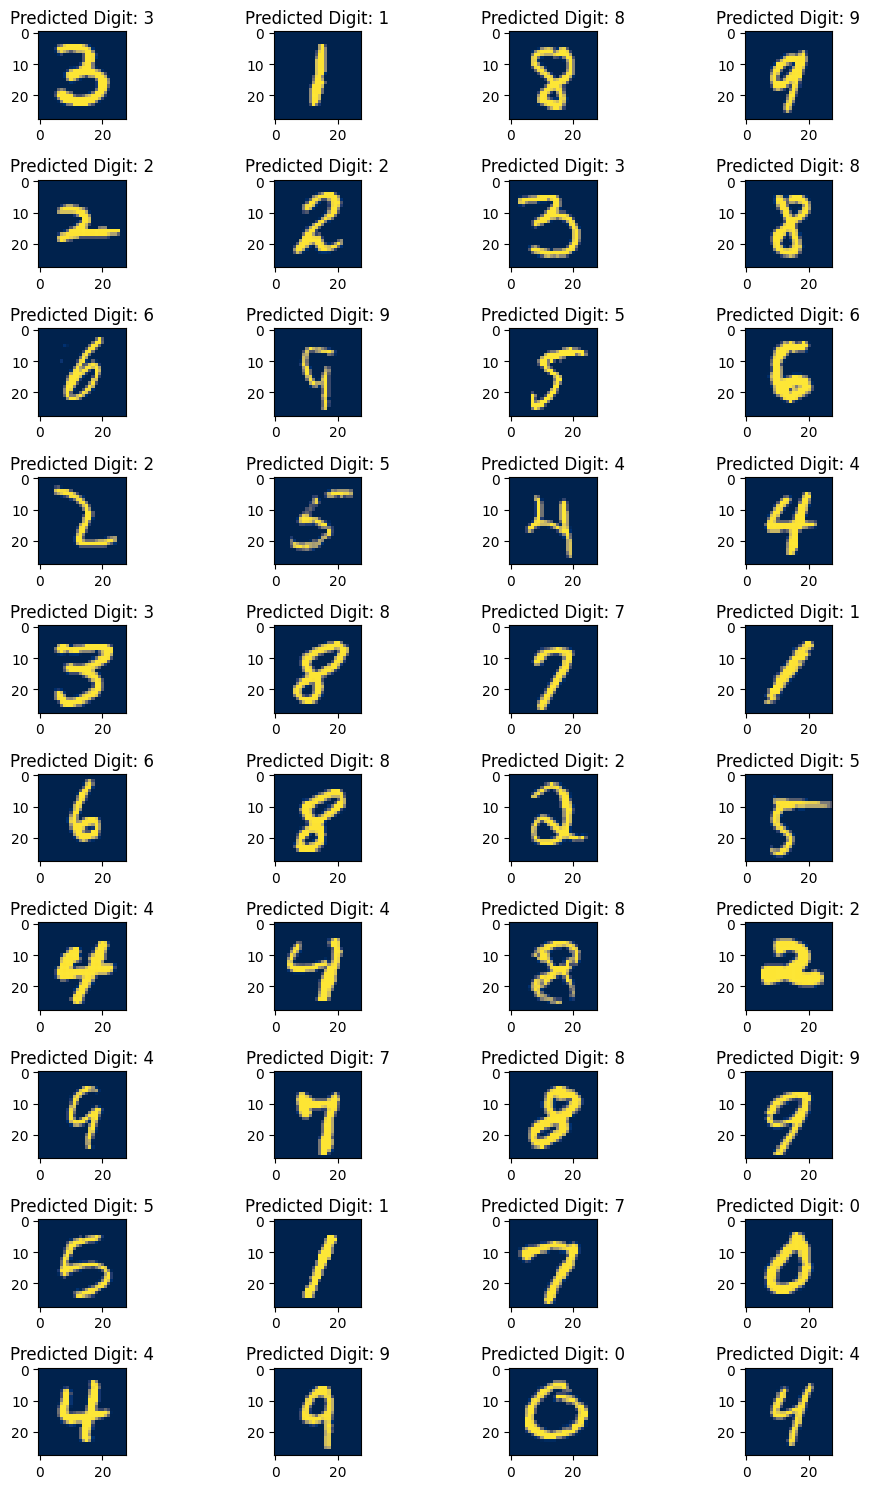

In [35]:
# Load the best model
best_model = MyNeuralNet()
best_model.load_state_dict(T.load("best_model.pth"))  # Load the saved best model
best_model = best_model.to(device)  # Move the model to the same device as your data

# Create a DataLoader for the test dataset (test_ds)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True)

# Create a subplot for 10 rows and 4 columns
fig, ax = plt.subplots(10, 4, figsize=(10, 15))

# Loop through the test dataset and make predictions
for i, (image, label) in enumerate(test_loader):
    if i >= 40:  # Plot the first 40 samples
        break

    # Move the image tensor to the same device as your model
    image = image.to(device)

    # Forward pass through the best_model to get predictions
    with T.no_grad():
        predicted_label = best_model(image)
        predicted_label = T.argmax(predicted_label, dim=-1).item()
    
    # Plot the image and predicted label
    plt.subplot(10, 4, i + 1)
    plt.imshow(image.squeeze().cpu().numpy(), cmap='cividis')
    plt.title(f"Predicted Digit: {predicted_label}")

fig.tight_layout()
plt.show()